## Imports

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

/home/maciej/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Some useful methods

In [2]:
def norm_data(data):
    scaler = preprocessing.StandardScaler().fit(data)
    return scaler.transform(data)

def get_XY(df, y_label):
    yn = df[y_label].as_matrix()
    Xn = df.drop(y_label, axis=1).as_matrix()

    return Xn, yn

def emp_length_mapping(lst):
    mapping = {}
    for elem in lst:
        if elem in ["n/a", "< 1 year"]:
            mapping[elem] = 0
        else:
            mapping[elem] = int(elem.split()[0].strip("+"))
        
    return mapping

def target_mapping(lst):
    mapping = {}
    for elem in lst:
        if elem in ["Default", "Charged Off", "Late (31-120 days)",
                   "Does not meet the credit policy. Status:Charged Off"]:
            mapping[elem] = 1
        else:
            mapping[elem] = 0
    
    return mapping

def threshold(vec, value):
    for i in range(len(vec)):
        if vec[i] >= value:
            vec[i] = 1
        else:
            vec[i] = 0
    return vec.astype(int)

def acc(y_correct, y_pred):
    acc = 0
    for i in range(len(y_pred)):
        acc += y_pred[i] == y_correct[i]
    
    return acc / len(y_pred)
    
pd.set_option('display.max_columns', None)
%matplotlib inline

## Read data from csv

In [3]:
data = pd.read_csv("LoanStats3a.csv", sep=",", error_bad_lines=False, low_memory=False,
                   parse_dates=["issue_d", "earliest_cr_line", "last_pymnt_d",
                                "next_pymnt_d", "last_credit_pull_d"])
data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,2011-12-01,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,1985-01-01,1.0,NaN,NaN,3.0,0.0,13648.0,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,2015-01-01,171.62,NaT,2016-01-01,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,2011-12-01,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,1999-04-01,5.0,NaN,NaN,3.0,0.0,1687.0,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,2013-04-01,119.66,NaT,2013-09-01,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,2011-12-01,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,small_business,real estate business,606xx,IL,8.72,0.0,2001-11-01,2.0,NaN,NaN,2.0,0.0,2956.0,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,2014-06-01,649.91,NaT,2016-01-01,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,2011-12-01,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0.0,1996-02-01,1.0,35.0,NaN,10.0,0.0,5598.0,21.0,37.0,f,0.0,0.0,12226.302212,12226.30,10000.00,2209.33,16.97,0.00,0.00,2015-01-01,357.48,NaT,2015-01-01,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,2011-12-01,Current,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > I plan on combi...,other,Personal,972xx,OR,17.94,0.0,1996-01-01,0.0,38.0,NaN,15.0,0.0,27783.0,53.9,38.0,f,766.9,766.9,3242.170000,3242.17,2233.10,1009.07,0.00,0.00,0.00,2016-01-01,67.79,2016-02-01,2016-01-01,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Preprocessing

### NULL values

Let's see how many NULL values we have in our data!

In [4]:
data.isnull().sum()

id                                  0
member_id                           0
loan_amnt                           0
funded_amnt                         0
funded_amnt_inv                     0
term                                0
int_rate                            0
installment                         0
grade                               0
sub_grade                           0
emp_title                       51457
emp_length                          0
home_ownership                      0
annual_inc                          4
verification_status                 0
issue_d                             0
loan_status                         0
pymnt_plan                          0
url                                 0
desc                           761350
purpose                             0
title                             151
zip_code                            0
addr_state                          0
dti                                 0
delinq_2yrs                        29
earliest_cr_

Unfortunately there are columns where most of values are NULLs. They are completely useless, so just remove those columns where more than 1% of the rows for that column contain a null value.

In [5]:
cleaned_data = data[[label for label in data if data[label].isnull().sum() <= 0.01 * data.shape[0]]]

Let's see how it looks like now!

In [6]:
cleaned_data.isnull().sum()

id                              0
member_id                       0
loan_amnt                       0
funded_amnt                     0
funded_amnt_inv                 0
term                            0
int_rate                        0
installment                     0
grade                           0
sub_grade                       0
emp_length                      0
home_ownership                  0
annual_inc                      4
verification_status             0
issue_d                         0
loan_status                     0
pymnt_plan                      0
url                             0
purpose                         0
title                         151
zip_code                        0
addr_state                      0
dti                             0
delinq_2yrs                    29
earliest_cr_line               29
inq_last_6mths                 29
open_acc                       29
pub_rec                        29
revol_bal                       0
revol_util    

Ok, much better. Now we have to do something with those NULL values. 
We can: 
- remove rows cointain NULL values, 
- fill them with median or mode value,
- or use some imputation and try to predict their missing values.

Let's try first option and see what will happen.

In [7]:
cleaned_data = cleaned_data.dropna()
cleaned_data.shape[0] / data.shape[0]

0.999080438009013

It looks good, we removed less than 1% of rows. I think it's good enough and there's no point to do something more with that.

### Remove useless columns

Let's take a look on data.

In [8]:
cleaned_data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,10+ years,RENT,24000.0,Verified,2011-12-01,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,credit_card,Computer,860xx,AZ,27.65,0.0,1985-01-01,1.0,3.0,0.0,13648.0,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,171.62,2016-01-01,0.0,1.0,INDIVIDUAL,0.0
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,< 1 year,RENT,30000.0,Source Verified,2011-12-01,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,car,bike,309xx,GA,1.00,0.0,1999-04-01,5.0,3.0,0.0,1687.0,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,119.66,2013-09-01,0.0,1.0,INDIVIDUAL,0.0
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,10+ years,RENT,12252.0,Not Verified,2011-12-01,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,small_business,real estate business,606xx,IL,8.72,0.0,2001-11-01,2.0,2.0,0.0,2956.0,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,649.91,2016-01-01,0.0,1.0,INDIVIDUAL,0.0
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,10+ years,RENT,49200.0,Source Verified,2011-12-01,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,other,personel,917xx,CA,20.00,0.0,1996-02-01,1.0,10.0,0.0,5598.0,21.0,37.0,f,0.0,0.0,12226.302212,12226.30,10000.00,2209.33,16.97,0.00,0.00,357.48,2015-01-01,0.0,1.0,INDIVIDUAL,0.0
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,1 year,RENT,80000.0,Source Verified,2011-12-01,Current,n,https://www.lendingclub.com/browse/loanDetail....,other,Personal,972xx,OR,17.94,0.0,1996-01-01,0.0,15.0,0.0,27783.0,53.9,38.0,f,766.9,766.9,3242.170000,3242.17,2233.10,1009.07,0.00,0.00,0.00,67.79,2016-01-01,0.0,1.0,INDIVIDUAL,0.0


- As we can see, two first columns contain randomly generated numbers, which are some identifiers. The column "url" also contains information about id,

- What's more, "zip_code" is redundant with the "addr_state" and only 3 digits of 5 digit code zip are visible,

- According to: https://www.lendingclub.com/public/rates-and-fees.action column sub_grade is reduntant to columns "grade" and "int_rate",

- "title" column requires a lot of processing to become usefull.

In [9]:
cleaned_data = cleaned_data.drop(["id", "member_id", "sub_grade", "url", "zip_code", "title"], axis=1)
cleaned_data.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq
0,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,10+ years,RENT,24000.0,Verified,2011-12-01,Fully Paid,n,credit_card,AZ,27.65,0.0,1985-01-01,1.0,3.0,0.0,13648.0,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,171.62,2016-01-01,0.0,1.0,INDIVIDUAL,0.0
1,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,< 1 year,RENT,30000.0,Source Verified,2011-12-01,Charged Off,n,car,GA,1.00,0.0,1999-04-01,5.0,3.0,0.0,1687.0,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,119.66,2013-09-01,0.0,1.0,INDIVIDUAL,0.0
2,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,10+ years,RENT,12252.0,Not Verified,2011-12-01,Fully Paid,n,small_business,IL,8.72,0.0,2001-11-01,2.0,2.0,0.0,2956.0,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,649.91,2016-01-01,0.0,1.0,INDIVIDUAL,0.0
3,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,10+ years,RENT,49200.0,Source Verified,2011-12-01,Fully Paid,n,other,CA,20.00,0.0,1996-02-01,1.0,10.0,0.0,5598.0,21.0,37.0,f,0.0,0.0,12226.302212,12226.30,10000.00,2209.33,16.97,0.00,0.00,357.48,2015-01-01,0.0,1.0,INDIVIDUAL,0.0
4,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,1 year,RENT,80000.0,Source Verified,2011-12-01,Current,n,other,OR,17.94,0.0,1996-01-01,0.0,15.0,0.0,27783.0,53.9,38.0,f,766.9,766.9,3242.170000,3242.17,2233.10,1009.07,0.00,0.00,0.00,67.79,2016-01-01,0.0,1.0,INDIVIDUAL,0.0


### Columns with only one value

Or not only one, but with values which have insignificant frequencies.

In [10]:
for label in list(cleaned_data):
    if len(cleaned_data[label].unique()) < 5:
        print(cleaned_data[label].value_counts())
        print("\n")

 36 months    620487
 60 months    266076
Name: term, dtype: int64


Source Verified    329332
Verified           290835
Not Verified       266396
Name: verification_status, dtype: int64


n    886553
y        10
Name: pymnt_plan, dtype: int64


f    456364
w    430199
Name: initial_list_status, dtype: int64


1.0    886563
Name: policy_code, dtype: int64


INDIVIDUAL    886061
JOINT            502
Name: application_type, dtype: int64




We can see that feature "pymnt_plan" has only two possible values: "n" and "y", but with only 10 occurrences of "y" (less than 1%), so definitely it is insignificant. The same with "application_type" feature: value "joint" has 0,05% frequency. 
On the other hand, feature "policy_code" has only one possible value, so it's absolutely useless for us.

In [11]:
cleaned_data = cleaned_data.drop(["pymnt_plan", "policy_code", "application_type"], axis=1)
cleaned_data.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,acc_now_delinq
0,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,10+ years,RENT,24000.0,Verified,2011-12-01,Fully Paid,credit_card,AZ,27.65,0.0,1985-01-01,1.0,3.0,0.0,13648.0,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,171.62,2016-01-01,0.0,0.0
1,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,< 1 year,RENT,30000.0,Source Verified,2011-12-01,Charged Off,car,GA,1.00,0.0,1999-04-01,5.0,3.0,0.0,1687.0,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,119.66,2013-09-01,0.0,0.0
2,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,10+ years,RENT,12252.0,Not Verified,2011-12-01,Fully Paid,small_business,IL,8.72,0.0,2001-11-01,2.0,2.0,0.0,2956.0,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,649.91,2016-01-01,0.0,0.0
3,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,10+ years,RENT,49200.0,Source Verified,2011-12-01,Fully Paid,other,CA,20.00,0.0,1996-02-01,1.0,10.0,0.0,5598.0,21.0,37.0,f,0.0,0.0,12226.302212,12226.30,10000.00,2209.33,16.97,0.00,0.00,357.48,2015-01-01,0.0,0.0
4,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,1 year,RENT,80000.0,Source Verified,2011-12-01,Current,other,OR,17.94,0.0,1996-01-01,0.0,15.0,0.0,27783.0,53.9,38.0,f,766.9,766.9,3242.170000,3242.17,2233.10,1009.07,0.00,0.00,0.00,67.79,2016-01-01,0.0,0.0


### Target  column

In [12]:
list(cleaned_data["loan_status"].unique())

['Fully Paid',
 'Charged Off',
 'Current',
 'Default',
 'Late (31-120 days)',
 'In Grace Period',
 'Late (16-30 days)',
 'Does not meet the credit policy. Status:Fully Paid',
 'Does not meet the credit policy. Status:Charged Off',
 'Issued']

Our goal is to prepare predictive model of default. Default client is defined as one with loan_status variable taking on the following levels: 'Charged Off', 'Default', 'Late (31-120 days)', 'Does not meet the credit policy. Status:Charged Off'. So this values we will define as ones and the rest as zeros.

In [13]:
cleaned_data["loan_status"] = cleaned_data["loan_status"].map(target_mapping(cleaned_data["loan_status"].unique()))

### Categorical features

To use any machine learning model we have to have only numerical data. So, let's do something with our non-numerical features!

In [14]:
cleaned_data.select_dtypes(include=["object"]).head()

,term,grade,emp_length,home_ownership,verification_status,purpose,addr_state,initial_list_status
0,36 months,B,10+ years,RENT,Verified,credit_card,AZ,f
1,60 months,C,< 1 year,RENT,Source Verified,car,GA,f
2,36 months,C,10+ years,RENT,Not Verified,small_business,IL,f
3,36 months,C,10+ years,RENT,Source Verified,other,CA,f
4,60 months,B,1 year,RENT,Source Verified,other,OR,f


- "initial_list_status" has only 2 possible values, so we can map it to 1/0 feature,
- "term" is a numerical feature, but we have to delete "months" from this,
- "emp_length" is also almost-numerical, just need some processing,
- "last_pymnt_amnt" is definitely numerical, so the parsing is enough,
- other features can be numerical after using pandas' "get_dummies()" method.

In [15]:
cleaned_data["initial_list_status"] = cleaned_data["initial_list_status"].map({"f": 1, "w": 0})
cleaned_data["term"] = cleaned_data["term"].str.split().str[0].astype("int")
cleaned_data["emp_length"] = cleaned_data["emp_length"].map(emp_length_mapping(cleaned_data["emp_length"].unique()))
cleaned_data["last_pymnt_amnt"] = cleaned_data["last_pymnt_amnt"].astype("float")
cleaned_data = pd.get_dummies(cleaned_data, columns=list(cleaned_data.select_dtypes(include=["object"])))

### Datetime features
We have datatype columns, but now it's useless - we have to extract some information from them.

In [16]:
cleaned_data.select_dtypes(include=["datetime"]).head()

,issue_d,earliest_cr_line,last_credit_pull_d
0,2011-12-01,1985-01-01,2016-01-01
1,2011-12-01,1999-04-01,2013-09-01
2,2011-12-01,2001-11-01,2016-01-01
3,2011-12-01,1996-02-01,2015-01-01
4,2011-12-01,1996-01-01,2016-01-01


In [17]:
datetime_features = list(cleaned_data.select_dtypes(include=["datetime"]))

for label in datetime_features:
    month_year = (cleaned_data[label].dt.month + cleaned_data[label].dt.year * 100)
    month_year_cnt_map = month_year.value_counts().to_dict()
    cleaned_data[label + "_month_year_cnt"] = month_year.map(month_year_cnt_map)
    
    cleaned_data[label + "_year"] = cleaned_data[label].dt.year
    cleaned_data[label + "_month"] = cleaned_data[label].dt.month

cleaned_data = cleaned_data.drop(datetime_features, axis=1)

In [18]:
cleaned_data.shape

(886563, 120)

Finally we have 886563 rows and 120 columns (119 features + target) in our data.

#### Now we are ready to specify some models!

## Model

In [21]:
X, y = get_XY(cleaned_data, "loan_status")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

indexes = [j for j in range(len(X_train))]
np.random.shuffle(indexes)
X_train = X_train[indexes]
y_train = y_train[indexes]

In [22]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [23]:
dtrain = xgb.DMatrix(X_train, y_train)
dval = xgb.DMatrix(X_val, y_val)
dtest = xgb.DMatrix(X_test)

xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 1.0,
    'colsample_bytree': 0.7,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'silent': 1
}

partial_model = xgb.train(xgb_params, dtrain, num_boost_round=10000, evals=[(dval, 'val')], 
                          early_stopping_rounds=20, verbose_eval=20)

num_boost_round = partial_model.best_iteration
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_round)

y_test_xgb = model.predict(dtest)

[0]	val-auc:0.91548
Will train until val-auc hasn't improved in 20 rounds.
[20]	val-auc:0.949694
Stopping. Best iteration:
[7]	val-auc:0.95273



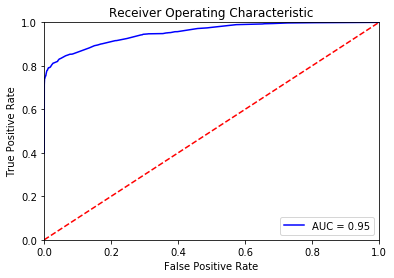

final results: 
- acc: 0.98
- F1: 0.82


In [24]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_xgb)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

y_test_xgb = threshold(y_test_xgb, 0.5)
print("""final results: 
- acc: %.2f
- F1: %.2f""" % (acc(y_test, y_test_xgb), f1_score(y_test, y_test_xgb)))